In [2]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import matplotlib.pyplot as plt
from scipy.fftpack import fft

In [3]:
def featureparam(a):
    """
    根据信号特征值处理数据
    :param a: numpy.ndarray
    :return: torch.tensor
    """
    x_avg = np.mean(a, axis=1, keepdims=True)  # 算术均值
    x_std = np.std(a, axis=1, ddof=1, keepdims=True)  # 标准差
    x_var = np.var(a, axis=1, ddof=1, keepdims=True)  # 方差
    x_ptp = np.ptp(a, axis=1, keepdims=True)  # 峰峰值
    x_rms = np.sqrt(np.mean(a ** 2, axis=1, keepdims=True))  # 有效值
    x_skw = stats.skew(a, axis=1).reshape(a.shape[0], 1)  # 偏度
    x_kur = stats.kurtosis(a, axis=1).reshape(a.shape[0], 1)  # 峰度
    feature = torch.from_numpy(np.array([x_avg, x_std, x_var,
                                         x_ptp, x_rms, x_skw, x_kur]).squeeze().T)
    return feature


def fastft(a):
    """
    根据傅里叶变换处理特征值
    :param a: numpy.ndarray
    :return: (torch.tensor, torch.tensor)
    """
    x = np.array([fft(a[i, :]) for i in range(a.shape[0])])
    y = np.array([np.abs(x[i, :]) for i in range(a.shape[0])])
    y = torch.from_numpy(y / (y.max() - y.min()))
    z = torch.from_numpy(np.array([np.angle(x[i, :]) for i in range(a.shape[0])]))

    return y, z

In [4]:
# 搭建1D-CNN网络
net = nn.Sequential(
    nn.Conv1d(1, 64, 3, 2, 1),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Conv1d(64, 32, 3, 2, 1),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(3, 2),

    nn.Conv1d(32, 16, 4, 3, 2),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 16, 4, 2, 2),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.MaxPool1d(2, 2),

    nn.Conv1d(16, 16, 4, 2, 2),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Linear(32, 1),
)

print(net)

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(32, 16, kernel_size=(4,), stride=(3,), padding=(2,))
  (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(2,))
  (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(2,))
  (15): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
from torchviz import make_dot
from torchvision.models import AlexNet

import os
os.environ["PATH"] += os.pathsep + 'C:\Users\ephemera\anaconda3\envs\mega\Lib\site-packages\graphviz\'

x=torch.rand(8,3,256,512)
model=AlexNet()
y=model(x)
g = make_dot(y)
g.view()

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'Digraph.gv'], make sure the Graphviz executables are on your systems' PATH

In [4]:
# 初始化网络参数
batch_size = 64
learning_rate = 0.02
num_epoches =10
# 初始化训练参数
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 构建随机梯度下降优化器, lr为学习率
loss_func = torch.nn.CrossEntropyLoss()  # 构建交叉熵损失函数
losses = []
acces = []
eval_losses = []  # 测试集损失和准确率
eval_acces = []

In [5]:
# 读入训练集并整理
train_set = np.loadtxt("train_remastered.csv", delimiter=",", dtype=("float32"), skiprows=1)
label = torch.from_numpy(train_set[:, [-1]]).long()
tseq = np.array(train_set[:, 1:-1])
# 计算数据特征
feature, _ = fastft(tseq)
print(feature.size())
deal_set = TensorDataset(feature, label)
train_data = DataLoader(dataset=deal_set, batch_size=batch_size, shuffle=True, num_workers=0)

torch.Size([792, 6000])


In [6]:
# 循环执行epoch
for e in range(num_epoches):
    train_loss = 0
    train_acc = 0
    net.train()  # 网络开始训练
    for im, label in train_data:
        im = Variable(torch.unsqueeze(im, dim=1).float())
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = loss_func(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)  # 挑选出输出时值最大的位置
        num_correct = (pred == label).sum().item()  # 记录正确的个数
        acc = num_correct / im.shape[0]  # 计算精确率
        train_acc += acc

    print("epoch %d finished: loss=%6f,  acc=%6f"
          % (e, train_loss / len(train_data), train_acc / len(train_data)))
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

epoch 0 finished: loss=2.569883,  acc=0.300881
epoch 1 finished: loss=1.812905,  acc=0.649439
epoch 2 finished: loss=1.101252,  acc=0.761218
epoch 3 finished: loss=0.763276,  acc=0.805288
epoch 4 finished: loss=0.568506,  acc=0.869391
epoch 5 finished: loss=0.393743,  acc=0.947115
epoch 6 finished: loss=0.252742,  acc=0.985577
epoch 7 finished: loss=0.145560,  acc=0.995593
epoch 8 finished: loss=0.097512,  acc=0.997596
epoch 9 finished: loss=0.058969,  acc=0.997596
epoch 10 finished: loss=0.042319,  acc=1.000000
epoch 11 finished: loss=0.035725,  acc=1.000000
epoch 12 finished: loss=0.026866,  acc=1.000000
epoch 13 finished: loss=0.023563,  acc=1.000000
epoch 14 finished: loss=0.020331,  acc=1.000000
epoch 15 finished: loss=0.017109,  acc=1.000000
epoch 16 finished: loss=0.017060,  acc=1.000000
epoch 17 finished: loss=0.014369,  acc=1.000000
epoch 18 finished: loss=0.013075,  acc=1.000000
epoch 19 finished: loss=0.010750,  acc=1.000000


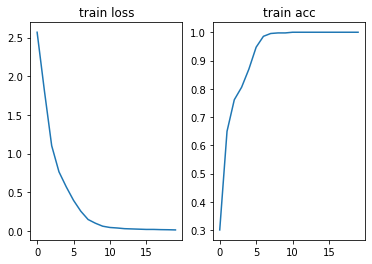

In [7]:
# 绘制测试曲线
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
ax.set_title('train loss')
ax.plot(np.arange(len(losses)), losses)
bx.set_title('train acc')
bx.plot(np.arange(len(acces)), acces)


In [11]:
# 读入测试集
test_set = np.loadtxt("test_remastered.csv", delimiter=",", dtype=("float32"), skiprows=1)
tseq = np.array(test_set[:, 1:])
feature, _ = fastft(tseq)
deal_set = TensorDataset(feature)
test_data = DataLoader(dataset=deal_set, batch_size=64, shuffle=False, num_workers=0)

In [53]:
net.eval()  # 将模型改为预测模式
res = []
for im in test_data:
    im = Variable(torch.unsqueeze(im[0], dim=1))
    out = net(im)
    _, pred = out.max(1)
    pred.unsqueeze_(1)
    res.append(pred)
res = torch.cat(res, dim=0)
print(res.size())
res = res.numpy().squeeze()
print(res.shape)
print(res)

torch.Size([528, 1, 1])
(528,)
[9, 7, 9, 0, 1, 7, 4, 7, 0, 3, 9, 0, 7, 0, 0, 7, 8, 9, 3, 0, 7, 2, 7, 5, 8, 9, 4, 0, 1, 8, 3, 7, 1, 0, 9, 0, 1, 4, 6, 9, 9, 3, 0, 7, 9, 8, 5, 9, 7, 8, 1, 7, 0, 7, 0, 2, 9, 9, 2, 5, 5, 7, 3, 6, 8, 6, 6, 9, 1, 5, 9, 1, 0, 3, 7, 9, 8, 0, 0, 8, 7, 2, 0, 0, 1, 1, 7, 4, 9, 0, 7, 0, 6, 7, 5, 8, 0, 7, 9, 0, 0, 9, 6, 3, 9, 3, 5, 0, 2, 7, 8, 7, 0, 9, 4, 9, 9, 1, 0, 9, 9, 2, 7, 7, 7, 8, 2, 6, 0, 4, 2, 3, 9, 7, 3, 8, 0, 0, 3, 0, 7, 5, 4, 9, 5, 0, 9, 7, 2, 4, 2, 9, 7, 0, 7, 2, 7, 0, 4, 2, 1, 0, 0, 3, 0, 7, 7, 6, 5, 1, 9, 0, 1, 4, 0, 7, 3, 9, 4, 8, 7, 9, 1, 2, 7, 9, 8, 0, 9, 9, 4, 7, 0, 7, 7, 5, 0, 7, 9, 1, 9, 0, 7, 6, 7, 7, 5, 0, 7, 8, 9, 4, 0, 9, 0, 9, 4, 1, 0, 9, 9, 4, 0, 7, 8, 9, 6, 9, 1, 3, 7, 3, 9, 0, 1, 3, 0, 7, 7, 0, 0, 1, 5, 8, 8, 9, 0, 2, 9, 2, 0, 6, 0, 9, 7, 6, 7, 0, 7, 7, 4, 0, 7, 0, 3, 9, 3, 9, 1, 2, 9, 7, 7, 6, 0, 9, 2, 5, 2, 7, 0, 5, 9, 7, 9, 9, 9, 3, 9, 7, 0, 2, 6, 4, 0, 0, 9, 9, 7, 7, 7, 4, 1, 3, 0, 8, 0, 7, 7, 8, 0, 7, 2, 7, 5, 9, 8, 7, 6, 4, 2, 8, 0,

In [63]:
import csv
headers = ['id','label']
rows = np.arange(1,529)
rows = np.vstack((rows,res)).transpose(1,0)
print(rows)
with open('pred.csv','w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    f_csv.writerows(rows)

[[  1   9]
 [  2   7]
 [  3   9]
 ...
 [526   6]
 [527   2]
 [528   0]]
